# 環境設定

In [ ]:
# Install HappyML
import os

if not os.path.isdir("HappyML"):
  os.system("git clone https://github.com/cnchi/HappyML.git")

In [ ]:
# Dataset Download

if not os.path.isfile("cats_and_dogs_filtered.zip"):
  !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

  # Unzip the file
  import zipfile

  zip_file = zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r')
  zip_file.extractall()
  zip_file.close()

--2023-11-14 07:35:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   246MB/s    in 0.3s    

2023-11-14 07:35:37 (246 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Dataset Path Setting
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'validation')

# Model Related Setting
to_train = True
image_size = 224
model_file = "CatsDogs_VGG16_224x224.h5" # 儲存模型檔案

# 照片前處理

In [ ]:
# Generate Training / Validation Set
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.75,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True)

train_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(image_size, image_size),
    batch_size=10,
    class_mode="binary",
    subset="training")

val_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(image_size, image_size),
    batch_size=10,
    class_mode="binary",
    subset="validation")

Found 500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [ ]:
# Generate Testing Set
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_set = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(image_size, image_size),
    batch_size=10,
    class_mode="binary")

Found 1000 images belonging to 2 classes.


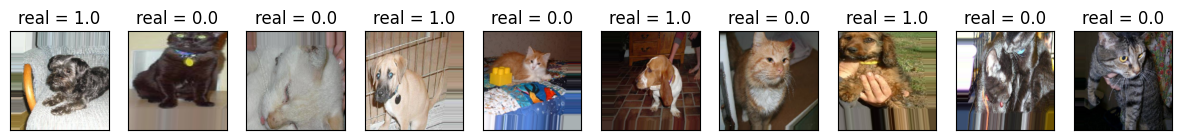

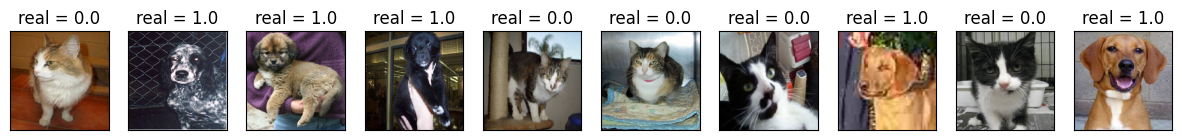

In [ ]:
# Validate the Success of Image Loading
import HappyML.model_drawer as md

# Print the first 10 images of Training Set
for data, label in train_set:
    md.show_first_n_images(x_ary=data, y_real=label, first_n=10, font_size=12)
    break

# Print the first 10 images of Testing Set
for data, label in test_set:
    md.show_first_n_images(x_ary=data, y_real=label, first_n=10, font_size=12)
    break

# 建造模型

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

# Create CNN Model Backbone
model = Sequential()

In [ ]:
# Load VGG16 as Convolutional Layers
vgg16 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Set the last 3 layers of VGG16 as trainable
is_trainable = ["block{}_conv{}".format(5, i) for i in range(1, 4)]

for layer in vgg16.layers:
    layer.trainable = True if layer.name in is_trainable else False

In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Add each layers & Compile
# Do not run this cell separately
# It will add additional layers and cause error
model.add(vgg16)
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation="relu"))
model.add(layers.Dense(units=1, activation="sigmoid"))

from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
 model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27560769 (105.14 MB)
Trainable params: 19925505 (76.01 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


# 模型訓練

In [ ]:
# Train & Save Model or Load Model
from tensorflow.keras.models import load_model

if to_train:
    model.fit(train_set, validation_data=val_set, epochs=10)
    model.save(model_file)
else:
    model = load_model(model_file)

Epoch 1/10
50/50 [==============================] - 50s 749ms/step - loss: 0.6266 - accuracy: 0.6560 - val_loss: 0.5506 - val_accuracy: 0.6987
Epoch 2/10
50/50 [==============================] - 30s 616ms/step - loss: 0.4322 - accuracy: 0.8240 - val_loss: 0.4877 - val_accuracy: 0.7540
Epoch 3/10
50/50 [==============================] - 31s 621ms/step - loss: 0.3356 - accuracy: 0.8620 - val_loss: 0.3645 - val_accuracy: 0.8287
Epoch 4/10
50/50 [==============================] - 32s 657ms/step - loss: 0.2738 - accuracy: 0.8940 - val_loss: 0.3252 - val_accuracy: 0.8527
Epoch 5/10
50/50 [==============================] - 31s 620ms/step - loss: 0.1904 - accuracy: 0.9280 - val_loss: 0.2675 - val_accuracy: 0.8853
Epoch 6/10
50/50 [==============================] - 31s 621ms/step - loss: 0.1954 - accuracy: 0.9240 - val_loss: 0.2928 - val_accuracy: 0.8827
Epoch 7/10
50/50 [==============================] - 50s 1s/step - loss: 0.1637 - accuracy: 0.9280 - val_loss: 0.3192 - val_accuracy: 0.8693
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 模型評估

In [ ]:
# Model Evaluation
test_loss, test_acc = model.evaluate(test_set)
print("Loss of Test:", test_loss)
print("Accuracy of Test:", test_acc)

100/100 [==============================] - 6s 57ms/step - loss: 0.1623 - accuracy: 0.9290
Loss of Test: 0.16230322420597076
Accuracy of Test: 0.9290000200271606


# 模型預測

100/100 [==============================] - 6s 55ms/step


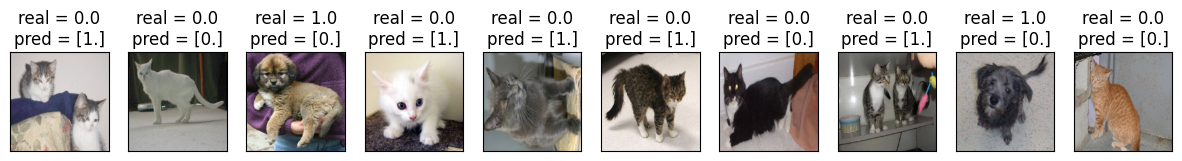

In [ ]:
# Model Testing
import numpy as np

Y_pred = np.rint(model.predict(test_set))

for data, label in test_set:
    md.show_first_n_images(x_ary=data, y_real=label, y_pred=Y_pred[:10], first_n=10, font_size=12)
    break

# 使用者照片預測

1/1 [==============================] - 0s 74ms/step
Cat


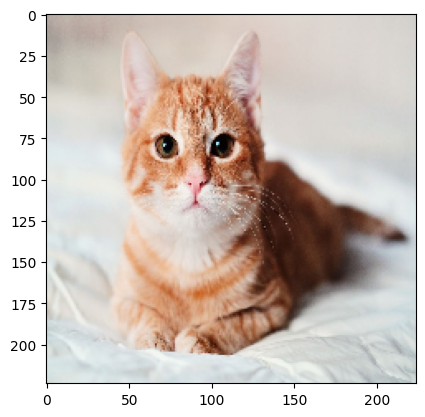

In [ ]:
from tensorflow.keras.preprocessing import image

user_image = image.load_img("cats_and_dogs_filtered/user/cat_or_dog_001.jpg", target_size=(image_size, image_size))
image_data = image.img_to_array(user_image) / 255
image_data = np.expand_dims(image_data, axis=0)

isDog = (model.predict(image_data) >= 0.5)
print("Dog" if isDog[0][0] else "Cat")

import matplotlib.pyplot as plt
plt.imshow(user_image)
plt.show()